# C19

In [1]:
class2idx = {'normal': 0, 'covid': 1}

idx2class = {idx:cl for cl, idx in class2idx.items()}


archs = ['resnet18', 'resnet50', 'resnet101', 'resnet152']

arch = archs[3]

inp_size = 224

epochs = 0

LR = 0.01
BS = 32

FREEZE = 7
optim_func = 'SGD'

ckpt = f'./data/model/{arch}.pth'

gpu = 'cuda:0'


In [2]:
%matplotlib inline 

import os
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import copy
import itertools
from collections import OrderedDict
import json
from datetime import datetime
import time 
from sklearn.metrics import confusion_matrix
import seaborn as sns

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import train_test_split
from skimage import io, transform
from IPython.display import display

import torch
import torchvision
from torch import optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.nn.functional as F

from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader


from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

print(torch.__version__)

manual_seed = 108
random.seed(manual_seed)
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.cuda.manual_seed_all(manual_seed)
torch.backends.cudnn.deterministic = True

device = gpu if torch.cuda.is_available() else 'cpu'

torch.cuda.empty_cache()

if device == 'cpu':
    epochs = 0
print('Executing for {} Epochs at {}'.format(epochs, device))    

1.3.1
Executing for 0 Epochs at cuda:0


In [3]:
os.makedirs('data/model', exist_ok=True)
os.makedirs('data/out', exist_ok=True)
os.makedirs('data/figs', exist_ok=True)

## Data Preparation

In [4]:
covid_path = 'data/covid-chestxray-dataset'
covid_images_path = f'{covid_path}/images' 
covid_metadata = f'{covid_path}/metadata.csv'

df = pd.read_csv(covid_metadata)
print(df.shape)
df.head(2)

(129, 16)


,Patientid,offset,sex,age,finding,survival,view,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 15
0,2,0.0,M,65.0,COVID-19,Y,PA,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN


In [5]:
def filter_covid(df):
    files = []
    for i, row in df.iterrows():
        if row['finding'] != 'COVID-19' or row['view'] != 'PA':
            continue
        else:
            files.append(row['filename'])
    return files

In [6]:
covid_images = filter_covid(df)
covid_images = [f'{covid_images_path}/{img}' for img in covid_images]
normal_images = glob.glob('./data/kaggle/train/NORMAL/*.jpeg')

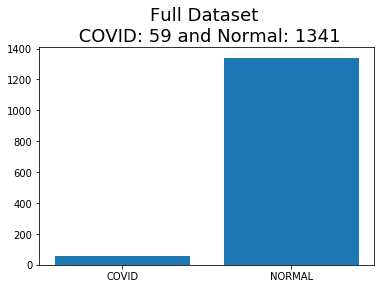

In [7]:
plt.bar( ['COVID', 'NORMAL'] ,[len(covid_images), len(normal_images)])
ttl = f'Full Dataset \n COVID: {len(covid_images)} and Normal: {len(normal_images)}'
plt.title(ttl, fontsize=18);

plt.savefig('./data/figs/dataset.jpg', bbox_inches='tight')

In [8]:
print(covid_images[0])
print(normal_images[0])

data/covid-chestxray-dataset/images/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
./data/kaggle/train/NORMAL/NORMAL2-IM-1318-0001.jpeg


In [9]:
def get_cat(img):
    if 'covid' in img:
        label = class2idx['covid']
        return label
    
    if 'NORMAL' in img:
        label = class2idx['normal']
        return label

In [10]:
# create a list of tuples (image, label)

X = covid_images + normal_images
X = random.sample(X, len(X))

def getXy(X):
    y = [get_cat(img) for img in X]
    Xy = list()
    for img, lbl in zip(X, y):
        tup = (img, lbl)
        Xy.append(tup)
    return Xy
  
if os.path.exists('./data/Xy.pkl'):
    with open('./data/Xy.pkl', 'rb') as f:
        Xy = pickle.load(f)
else:
    Xy = getXy(X)
    with open('./data/Xy.pkl', 'wb') as f:
        pickle.dump(Xy, f)
print(len(Xy))

1400


## Split Data

In [11]:
X = [X[0] for X in Xy]
y = [X[1] for X in Xy]

print(len(X), len(y))

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.25, stratify=y, random_state=manual_seed)

Xy_train = [(img, lbl) for img, lbl in zip(X_train, y_train)]
Xy_valid = [(img, lbl) for img, lbl in zip(X_valid, y_valid)]

print(Xy_train[:2])
print(len(Xy_train))

print(Xy_valid[:2])
print(len(Xy_valid))

1400 1400
[('./data/kaggle/train/NORMAL/NORMAL2-IM-1282-0001.jpeg', 0), ('./data/kaggle/train/NORMAL/NORMAL2-IM-0682-0001.jpeg', 0)]
1050
[('./data/kaggle/train/NORMAL/NORMAL2-IM-0885-0001.jpeg', 0), ('./data/kaggle/train/NORMAL/NORMAL2-IM-0396-0001.jpeg', 0)]
350


In [12]:
y_train_count = np.unique(y_train, return_counts=True)
y_valid_count = np.unique(y_valid, return_counts=True)
print(sum(y_train_count[1]), sum(y_valid_count[1]))
print(y_train_count)
print(y_valid_count)

1050 350
(array([0, 1]), array([1006,   44]))
(array([0, 1]), array([335,  15]))


## Weighted Sampling

In [13]:
train_count = list(y_train_count[1])
weight_per_class = [0.] * len(class2idx)
N = float(sum(train_count))
print(N)

for i in range(len(class2idx)):                                                   
    weight_per_class[i] = N/float(train_count[i])  
print(weight_per_class)

weights = [0] * int(N)

for idx, val in enumerate(Xy_train):                                          
    weights[idx] = weight_per_class[val[1]]  
    
print(len(weights))

weights = torch.DoubleTensor(weights)                                       
sampler = WeightedRandomSampler(weights, len(weights)) 

1050.0
[1.0437375745526838, 23.863636363636363]
1050


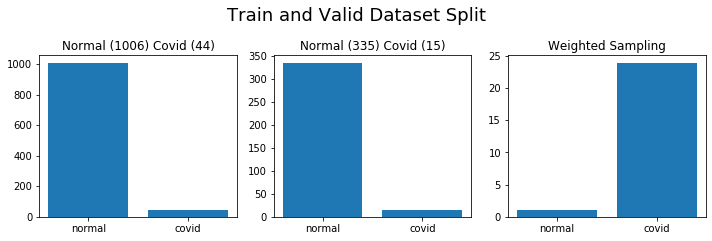

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].bar(list(class2idx.keys()), list(y_train_count[1]))
ax[1].bar(list(class2idx.keys()), list(y_valid_count[1]))
ax[2].bar(list(class2idx.keys()), weight_per_class)


ttl = f'Normal ({y_train_count[1][0]}) Covid ({y_train_count[1][1]})'
ax[0].set_title(ttl)

ttl = f'Normal ({y_valid_count[1][0]}) Covid ({y_valid_count[1][1]})'
ax[1].set_title(ttl)

ttl = f'Weighted Sampling'
ax[2].set_title(ttl)



#ttl = f'COVID: {len(covid_images)} and Normal: {len(normal_images)}'
plt.suptitle('Train and Valid Dataset Split', fontsize=18, y=1.1);
plt.tight_layout();

plt.savefig('./data/figs/dataset_split.jpg', bbox_inches='tight')

## Data Augumentation

In [15]:
# Transforms

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

tt = [transforms.Resize(360)]

tt.extend([transforms.CenterCrop(inp_size)])

tt.extend([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()])
tt.extend([transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)])

tv = [transforms.Resize(360), transforms.CenterCrop(inp_size)]

both = [#transforms.Grayscale(num_output_channels=1), 
        transforms.ToTensor(), 
        transforms.Normalize(mean, std)
       ]

tt.extend(both)
tv.extend(both)

train_transform = transforms.Compose(tt)
valid_transform = transforms.Compose(tv)

# Dataset and Dataloader

In [16]:
# Dataset to be used for training

class MyDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.paths[idx]
        #image = io.imread(img_name)
        #image = Image.fromarray(image)
        
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = get_cat(img_name)
        
        return image, label, img_name

In [17]:
dataset_train = MyDataset(X_train, transform=train_transform)
dataset_valid = MyDataset(X_valid, transform=valid_transform)

In [18]:
loader_train = torch.utils.data.DataLoader(dataset_train, \
                                           batch_size=BS, shuffle=False, \
                                           sampler=sampler, num_workers=2,\
                                           pin_memory=True)

loader_valid = torch.utils.data.DataLoader(dataset_valid, \
                                           batch_size=BS, shuffle=True) 

In [19]:
# Check if weighted sampling working OK
lbls = []
for idx, (imgs, labels, names) in enumerate(loader_train):
    lbls.extend(labels.tolist())
    counter = Counter(lbls)
    counter = sorted(counter.items(), key = lambda i: i[0])
    print(idx+1, imgs.shape, labels.shape, len(names))
    print('   ', counter)
    break

1 torch.Size([32, 3, 224, 224]) torch.Size([32]) 32
    [(0, 14), (1, 18)]


## Sample

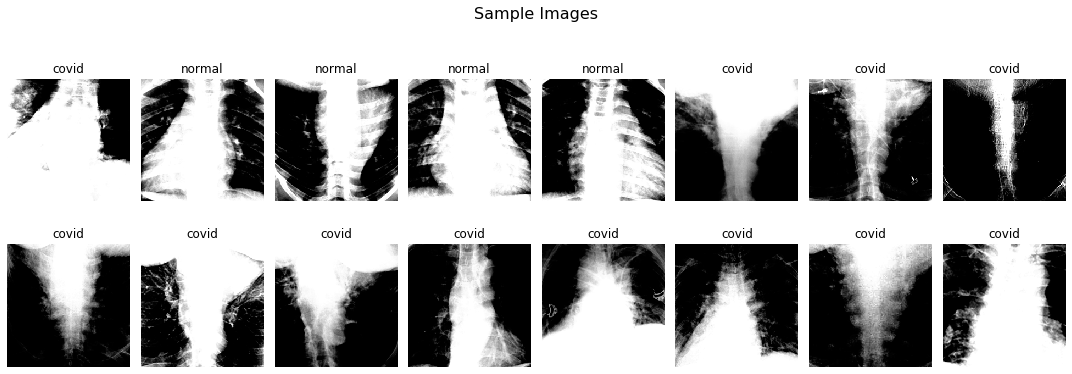

In [49]:
images, labels, names = next(iter(loader_train))
names = list(names)

from skimage.color import rgb2gray

fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(15, 5))
idx = 0
for r in range(2):
    for c in range(8):
        ax = axs[r, c]
        img = images[idx]
        
        img = np.transpose(img, (1, 2, 0))
        img = img.numpy().clip(0, 1)
        
        img = rgb2gray(img)
        
        lbl = labels[idx].item()
        lbl = idx2class[lbl]
        
        ax.imshow(img, cmap='gray')
        ax.set_title(lbl)
        idx += 1 
        ax.axis('off')
plt.suptitle('Sample Images', fontsize=16, y=1.1);
plt.tight_layout()

plt.savefig('./data/figs/sample_images.jpg', bbox_inches='tight')

In [47]:
img.shape

(224, 224)

# Model

In [21]:
get_model = getattr(torchvision.models, arch)
model = get_model(pretrained=True)

In [22]:
model.fc = nn.Linear(model.fc.in_features, len(class2idx))
model.fc

Linear(in_features=2048, out_features=2, bias=True)

In [23]:
for idx, child in enumerate(model.children()):
    print('Layer ', idx, ':\n', child, end='\n\n')

Layer  0 :
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Layer  1 :
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Layer  2 :
 ReLU(inplace=True)

Layer  3 :
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Layer  4 :
 Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [24]:
for param in model.parameters():
    param.requires_grad = True
    
# Check Gradient status for all layers
for idx, child in enumerate(model.children()):
    for param in child.parameters():
        print(idx, '->', param.requires_grad)
        break

0 -> True
1 -> True
4 -> True
5 -> True
6 -> True
7 -> True
9 -> True


In [25]:
# Freeze initial layers
for idx, child in enumerate(model.children()):
    if idx < FREEZE:
        for param in child.parameters():
            param.requires_grad = False
            
# Check Gradient status of all layers after freezing initial layers
for idx, child in enumerate(model.children()):
    for param in child.parameters():
        print(idx, '->', param.requires_grad)
        break

0 -> False
1 -> False
4 -> False
5 -> False
6 -> False
7 -> True
9 -> True


# Train

In [26]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()

if optim_func == 'SGD':
    optimizer = optim.SGD(model.fc.parameters(), lr=LR, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)

In [27]:
def train(model):
        
    loss_train, correct_train, acc_train = 0.0, 0, 0.0
    loss_valid, correct_valid, acc_valid = 0.0, 0, 0.0
    total_train, total_valid = len(dataset_train), len(dataset_valid)
    
    # -------------- Train --------------------------------
    model.train()
    loader = loader_train
    for idx, (inputs, labels, names) in enumerate(loader):
        print('T: {}/{}'.format(idx+1, len(loader)), end='\r', flush=True)
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
                        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item() * inputs.size(0)
            
            ps = torch.nn.functional.softmax(outputs, dim=1)
            preds = ps.max(1, keepdim=True)[1]
            correct_train += preds.eq(labels.view_as(preds)).sum().item()
        
    loss_train = loss_train / total_train
    acc_train = correct_train / total_train
    
    # -------------- Valid --------------------------------
    model.eval()
    loader = loader_valid
    for idx, (inputs, labels, names) in enumerate(loader):
        print('V: {}/{}'.format(idx+1, len(loader)), end='\r', flush=True)
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.set_grad_enabled(False):
                        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss_valid += loss.item() * inputs.size(0)
            
            ps = torch.nn.functional.softmax(outputs, dim=1)
            preds = ps.max(1, keepdim=True)[1]
            correct_valid += preds.eq(labels.view_as(preds)).sum().item()
        
    loss_valid = loss_valid / total_valid
    acc_valid = correct_valid / total_valid
    
    
    return model, loss_train, acc_train, loss_valid, acc_valid

In [28]:
f = f'./data/out/log-{arch}.json'

if os.path.exists(ckpt):

    checkpoint = torch.load(ckpt, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    acc_valid_max = checkpoint['acc_valid_max']
    
    print('Model Loaded')
    
    with open(f, 'r') as fp:
        log_json = json.load(fp)
        
    losses_train = log_json['losses_train']
    losses_valid = log_json['losses_valid']
    
    acces_train = log_json['acces_train']
    acces_valid = log_json['acces_valid']
    
    LRs = log_json['LRs']
    BSs = log_json['BSs']
    
    times = log_json['times']
    
if not os.path.exists(ckpt):
    losses_train, losses_valid = [], []
    acces_train, acces_valid = [], []
    LRs, BSs, times = [], [], []
    acc_valid_max = 0
    
    log_json = {
        'losses_train': losses_train, 'losses_valid': losses_valid,
        'acces_train': acces_train, 'acces_valid': acces_valid,
        'LRs': LRs, 'BSs': BSs, 'times': times
    }

Model Loaded


In [29]:
for epoch in range(epochs):
    
    start=datetime.now()
    model, loss_train, acc_train, loss_valid, acc_valid = train(model)
    time = datetime.now() - start
    time = time.seconds
    
    loss_train, acc_train, loss_valid, acc_valid = \
    round(loss_train, 3), round(acc_train, 3), \
    round(loss_valid, 2), round(acc_valid, 2)
    
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)
    acces_train.append(acc_train)
    acces_valid.append(acc_valid)
    LRs.append(LR)
    BSs.append(BS)
    times.append(time)
    
    print('Run: {}/{} -> Train: {}-{} -> Valid: {}-{}'.\
          format(epoch+1, epochs, loss_train, acc_train, loss_valid, acc_valid))
    
    log_json = {
        'losses_train': losses_train, 'losses_valid': losses_valid,
        'acces_train': acces_train, 'acces_valid': acces_valid,
        'LRs': LRs, 'BSs': BSs, 'times': times
    }
    
    if acc_valid > acc_valid_max:
        best_model_weights = copy.deepcopy(model.state_dict())
        acc_valid_max = acc_valid
        checkpoint_dict = {
            'state_dict': model.state_dict(),
            'acc_valid_max': acc_valid_max,
            'log_json': log_json
        }
        torch.save(checkpoint_dict, ckpt)
        print('   model saved')

In [30]:
if epochs > 0:
    with open(f, 'w') as fp:
        json.dump(log_json, fp, indent=4)

# Results

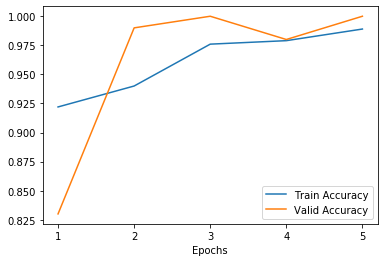

In [31]:
fig = plt.figure()

epochs = list(range(1, len(losses_train)+1))
plt.plot(epochs, acces_train, label="Train Accuracy")
plt.plot(epochs, acces_valid, label="Valid Accuracy")
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.legend();
fig.savefig(f'./data/figs/{arch}-accuracy.jpg')

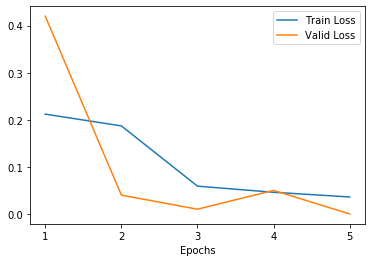

In [32]:
fig = plt.figure()

epochs = list(range(1, len(losses_train)+1))
plt.plot(epochs, losses_train, label="Train Loss")
plt.plot(epochs, losses_valid, label="Valid Loss")
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.legend();
fig.savefig(f'./data/figs/{arch}-loss.jpg')

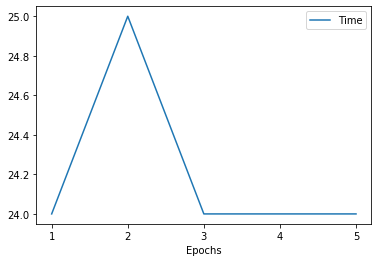

In [33]:
fig = plt.figure()

epochs = list(range(1, len(losses_train)+1))
plt.plot(epochs, times, label="Time")
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.legend();
fig.savefig(f'./data/figs/{arch}-time.jpg')

# Test

In [34]:
def test(model, loader):
    y_obs, y_pred = [], []
    
    model.eval()
    
    for idx, (inputs, labels, names) in enumerate(loader):
        print('{}/{}'.format(idx+1, len(loader)), end='\r')
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
        ps = torch.exp(outputs)

        #_, preds = torch.max(outputs, 1)
        _, preds = torch.max(ps, 1)

        y_obs.append(labels.data.tolist())
        y_pred.append(preds.tolist())
    
    y_obs = list(itertools.chain.from_iterable(y_obs)) # flat
    y_pred = list(itertools.chain.from_iterable(y_pred))

    stack = (y_obs, y_pred)
    
    return stack

In [35]:
# Valid Accuracy

f = f'./data/out/{arch}.csv'
if os.path.exists(f):
    df = pd.read_csv(f)
    display(df.head(2))
else:
    loader = loader_valid
    stack = test(model, loader)
    header = 'y_obs,' + 'y_pred'
    np.savetxt(f, np.column_stack(stack), delimiter=",", fmt='%i,%i',\
               header=header, comments='')
    df = pd.read_csv(f)
    display(df.head(2))

,y_obs,y_pred
0,0,0
1,0,0


In [36]:
def conf_mat(df, nclasses, classes=None):
    shape = (nclasses, nclasses)
    mat = np.zeros(shape)
    for i in range(len(df['y_obs'])):
        obs = df.iloc[i, 0]
        pred = df.iloc[i, 1]
        mat[obs, pred] = mat[obs, pred] + 1

    idxo = ['obs-'+str(i) for i in range(nclasses)]
    idxp = ['pred-' + str(i) for i in range(nclasses)]
    if classes:
        idxo = ['actual-'+cl for cl in classes]
        idxp = ['pred-'+cl for cl in classes]
    df = pd.DataFrame(mat, index=idxo, dtype='int32', columns=idxp)
    return df

In [37]:
# Train 
conf_mat(df, len(class2idx), class2idx.keys())

,pred-normal,pred-covid
actual-normal,335,0
actual-covid,1,14


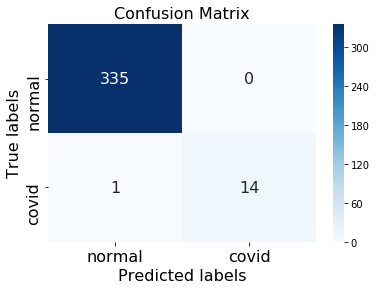

In [38]:
y_true = df['y_obs']
y_pred = df['y_pred']

cm = confusion_matrix(y_true, y_pred)

ax = plt.subplot()

sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap=plt.get_cmap('Blues'), annot_kws={"size": 16});

ax.set_xlabel('Predicted labels', fontsize=16);
ax.set_ylabel('True labels', fontsize=16); 

ax.set_title('Confusion Matrix', fontsize=16, y=1.5); 

ax.xaxis.set_ticklabels(class2idx.keys(), fontsize=16); 
ax.yaxis.set_ticklabels(class2idx.keys(), fontsize=16);

plt.savefig('./data/figs/conf_mat.jpg', bbox_inches='tight')

# Inference

In [39]:
def predict_covid(model, img_name):
    
    img = Image.open(img_name).convert('RGB')
    img = valid_transform(img)    
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()
    with torch.set_grad_enabled(False):
        out = model(img)    
    ps = torch.nn.functional.softmax(out, dim=1)
    pred = ps.max(1, keepdim=True)[1]
    label = pred.item()
    
    return label 

checkpoint = torch.load(ckpt, map_location=device)

model.load_state_dict(checkpoint['state_dict']);

In [40]:
img = random.choice(Xy_valid)[0]
print(img)
class_id = predict_covid(model, img)

print(idx2class[int(class_id)])

./data/kaggle/train/NORMAL/NORMAL2-IM-0406-0001.jpeg
normal


In [41]:
Xy_valid_covid = [t for t in Xy_valid if t[1]==1]
Xy_valid_normal = [t for t in Xy_valid if t[1]==0]

total = 48
s1 = len(Xy_valid_covid)
if len(Xy_valid_covid) > 24:
    s1 = 24
s2 = 48 - s1

images1 = random.sample(Xy_valid_covid, s1)
images2 = random.sample(Xy_valid_normal, s2)
images = images1 + images2
images = random.sample(images, len(images))

In [42]:
for img, actual_label in Xy_valid_covid[:5]:
    pred_label = predict_covid(model, img)
    print(pred_label)

0
1
1
1
1


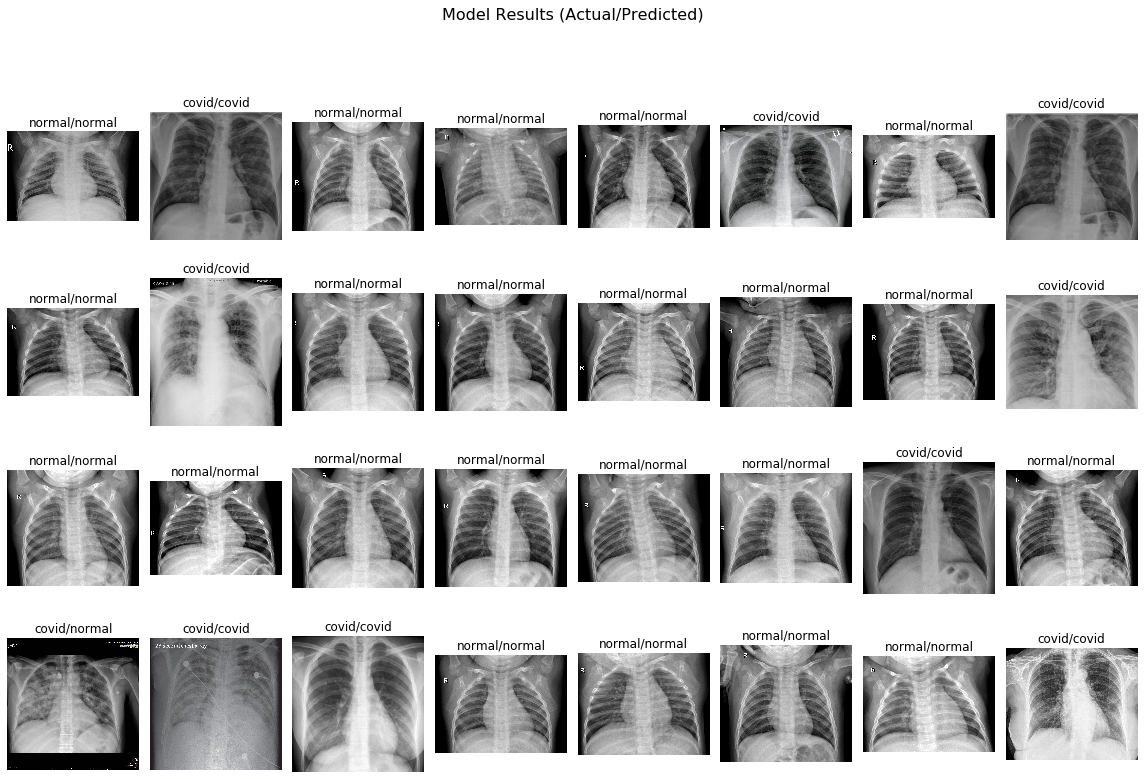

In [43]:
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(16, 10))

idx = 0
for r in range(4):
    for c in range(8):
        ax = axs[r, c]
        
        img = images[idx][0]
        
        class_actual = idx2class[images[idx][1]]

        class_id = predict_covid(model, img)
        class_pred = idx2class[int(class_id)]
        #class_pred = idx2class[class_pred]

        ttl = f'{class_actual}/{class_pred}'
        
        img = Image.open(img)#.convert('RGB')
        
        ax.imshow(img, cmap='gray')
        ax.set_title(ttl)
        idx += 1 
        ax.axis('off')
plt.suptitle('Model Results (Actual/Predicted)', fontsize=16, y=1.1);
plt.tight_layout()

plt.savefig('./data/figs/model_results.jpg', bbox_inches='tight')